# Data exploration in the PSA with EPN-TAP
- EPN-TAP is a Europlanet extension of TAP for planetary science
- The PSA supports access to products via EPN-TAP
  - EPN-TAP allows queries to the database not possible with other interfaces
- Data in the PSA are archived in PDS [PDS](https://pds.nasa.gov/) format
    - each archive item consists of product + label
        - PDS3 = previous standard (labels in PVL)
        - PDS4 = current standard (labels in XML)
- PSA data are highly diverse
    - from microscope to telescopes
    - on orbiters, flybys, landers etc.
- This notebook shows a few quick examples
  - query products and explore
  - unpack and visualise some camera data
  - unpack and visualise some AFM data

In [ ]:
import zipfile, struct, warnings, requests, struct, os
from pathlib import PurePath
from io import BytesIO

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import astropy, skimage
from astropy.io.votable import parse_single_table
from astroquery.utils.tap.core import Tap
import pvl

from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode()

import IPython.display as display
from PIL import Image

%matplotlib inline
warnings.simplefilter('ignore')

In [ ]:
tap_url = 'https://archives.esac.esa.int/psa/epn-tap/tap/'
psa = Tap(url=tap_url)

## PSA data exploration

Run some simple queries to get some statistics about the data in the PSA

### How many products are there in the archive?

In [ ]:
query = 'SELECT COUNT(1) from epn_core'
result = psa.launch_job(query).get_data()
result['count'][0]

### How big is the archive?

In [ ]:
query = 'SELECT SUM(access_estsize) from epn_core' 
result = psa.launch_job(query).get_data() # in kbyte
result['sum'][0]/1024./1024./1024.

### What are the _largest_ products?

In [ ]:
query = 'SELECT TOP 10 granule_uid, access_estsize from epn_core WHERE access_estsize IS NOT NULL ORDER BY access_estsize DESC'
result = psa.launch_job(query).get_data()
result

### What missions does the PSA host?

In [ ]:
query = 'SELECT DISTINCT instrument_host_name from epn_core'
result = psa.launch_job(query).get_data()
result

### How many different targets are there in the archive?

In [ ]:
query = 'SELECT DISTINCT target_name FROM epn_core'
result = psa.launch_job(query).get_data()
result

## OK, what data do we have about Mars - show me missions!

In [ ]:
query = "SELECT DISTINCT instrument_host_name FROM epn_core WHERE target_name='Mars'"
missions = psa.launch_job(query).get_data()
missions

## Interesting - Rosetta observed Mars! With which instruments?

In [ ]:
query = "SELECT DISTINCT instrument_name FROM epn_core WHERE target_name='Mars' AND instrument_host_name='Rosetta'"
instruments = psa.launch_job(query).get_data()
instruments

## OSIRIS is the camera, right? What data did it produce?

This time putting the table into pandas since I'm more comfortable with it

In [ ]:
query = "SELECT * FROM epn_core WHERE target_name='Mars' AND instrument_name='OSIRIS'"
osiris_mars = psa.launch_job(query).get_data().to_pandas()
print(len(osiris_mars))
osiris_mars

## Let's just tidy that up a bit

- There are lots of columns with "Nan"s because not all fields can be (easily) populated due to the diverse nature of the instruments
    - remove those 
- and get the strings in utf8...

In [ ]:
osiris_mars.dropna(axis=1, how='all', inplace=True)

str_df = osiris_mars.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    osiris_mars[col] = str_df[col]

## Let's look at one entry

In [ ]:
osiris_mars.iloc[0]

Ahh, thumbnails are provided!

Great, I don't have to work hard to get a sneak preview! Let's look at an example - we can show images directly in the Notebook:

In [ ]:
display.Image(osiris_mars.thumbnail_url.iloc[0], width=500, embed=True)

We can also grab a bunch of images and show them using matplotlib (easier to tile etc.). Let's take the first 9:

In [ ]:
f, axarr = plt.subplots(3, 3, figsize=(16,16))
curr_row = 0
for idx, product in osiris_mars.iloc[0:9].iterrows():
    response = requests.get(url=product['thumbnail_url'])
    im = Image.open(BytesIO(response.content))
    col = idx % 3
    axarr[col, curr_row].imshow(im, cmap=matplotlib.cm.gray)
    axarr[col, curr_row].xaxis.set_visible(False)
    axarr[col, curr_row].yaxis.set_visible(False)    
    if col == 2:
        curr_row += 1

## Tell me more about that first image

In [ ]:
osiris_mars.iloc[0]

So I have a URL for direct access, and a format - which the MIME code tell me is a zip.

In [ ]:
access_url = osiris_mars.iloc[0].access_url
access_url

Let's download the zip on the fly and see what's in it...

In [ ]:
r = requests.get(url=access_url)
zip = zipfile.ZipFile(BytesIO(r.content))
zipfiles = zip.namelist()
zipfiles

So the product actually consists of the image file with attached label, and a browse product. We need to get the file in the DATA directory to work with the actual data...


In [ ]:
data_file = [file for file in zipfiles if PurePath(file).parts[1]=='DATA'][0]
data_file

Ooh, attached PDS3 labels are nasty - I picked a bad example! Still, we can deal with it - find the label length by parsing until we hit "END"

In [ ]:
def read_label():
    label = []
    with zip.open(data_file) as f:  
        line = f.readline().decode('utf8')
        while line.strip() != 'END':
            if line.strip() == '':
                line = f.readline().decode('utf8')
                continue
            else:
                label.append(line.strip())
                line = f.readline().decode('utf8')
            
    return label

label = read_label()

In [ ]:
len(label)

Oof, that's a lot of meta-data! PDS3 labels are stored in "Parameter Value Language" (PVL) which we can pass to get a dictionary...

In [ ]:
meta = pvl.loads('\r\n'.join(label))
meta

Now we have all of the PDS3 meta-data ready to be used. We can use the IMAGE pointer to tell us where to get the actual image array

In [ ]:
offset = (meta['^IMAGE']-1) * meta['RECORD_BYTES']
offset

But we need a bit more meta-data to open it correctly...

In [ ]:
meta['IMAGE']

In [ ]:
rows = meta['IMAGE']['LINES']
cols = meta['IMAGE']['LINE_SAMPLES']
samples = rows * cols

OK, how we have enough to unpack the data!

In [ ]:
data = struct.unpack_from('<%dH' % samples, zip.open(data_file).read(), offset)

In [ ]:
 data = np.array(data).reshape((cols, rows))

In [ ]:
fig, ax = plt.subplots(figsize=(14,14))
im = ax.imshow(data, cmap=matplotlib.cm.gray, interpolation='nearest')

Check the minimum, maximum and mean values to compare with the label:

In [ ]:
meta['IMAGE']['DERIVED_MINIMUM'], meta['IMAGE']['DERIVED_MAXIMUM'], meta['IMAGE']['MEAN']

In [ ]:
data.min(), data.max(), data.mean()

Now we have the real data, not just a preview, and can try things like histograms

In [ ]:
fig_hist, ax_hist = plt.subplots(figsize=(14,10))
ax_hist.hist(data.ravel(), bins=256, histtype='step', color='black')
ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax_hist.set_xlabel('Pixel intensity')
ax_hist.set_yticks([]);

Now we can play with things like adaptive histogram equalisation:

In [ ]:
img_adapteq = skimage.exposure.equalize_adapthist(data, clip_limit=0.03)

In [ ]:
fig, ax = plt.subplots(figsize=(14,14))
im = ax.imshow(img_adapteq, cmap=matplotlib.cm.gray, interpolation='nearest')

# MIDAS data
- MIDAS was an Atomic Force Microscope on Rosetta
- Query and extract data into pandas as before

In [ ]:
query = "SELECT * FROM epn_core WHERE target_name='67P' AND instrument_name='MIDAS'"
data = psa.launch_job(query).get_data().to_pandas()

# tidy it up a little
str_df = data.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    data[col] = str_df[col]
    
len(data)

Note that this number is limited by the AstroQuery implementation for syncronous queries!

In [ ]:
data.granule_gid.unique()

## MIDAS specific filtering of products

Each MIDAS product is described by a three-letter acronym at the start. You can read more about the archiving conventions here: http://pdssbn.astro.umd.edu/holdings/ro-c-midas-3-esc2-samples-v1.0/document/mid_eaicd.pdf. If you want to get really technical you can also look at the User Manual [http://pdssbn.astro.umd.edu/holdings/ro-c-midas-3-esc2-samples-v1.0/document/mid_user.pdf].

MIDAS images all start with IMG and the two letters at the end of the product name describe the image channels used - the most useful is ZS, which is the topographic channel. So we'll add some new colums to allow us to select the data type and channel, and filter to just those:

In [ ]:
data['product_id'] = data.granule_uid.apply( lambda uid: uid.split(':')[-1])
data['data_type'] = pd.Series(data.product_id.apply( lambda prod: prod[0:3] ), name='data_type')
images = data[ data.data_type=='IMG' ].copy()
images['channel'] = images.product_id.apply( lambda prod: prod[-2:] )
images = images[ images.channel=='ZS' ]
images.head()

## Choose an image

Here we will look at a specific image used in a recent paper. The product ID is:
* IMG_1501323_1504200_013_ZS (ESC1)

In [ ]:
image1 = 'IMG_1501323_1504200_013_ZS'
access_url = data[data.product_id==image1].access_url.squeeze()

In [ ]:
r = requests.get(url=access_url)
zip = zipfile.ZipFile(BytesIO(r.content))
zip.namelist()

In [ ]:
label_file = [filename for filename in zip.namelist() if filename.endswith('.LBL')][0]
label = pvl.load(zip.open(label_file))

data_file = [filename for filename in zip.namelist() if filename.endswith('.IMG')][0]
rawdata = zip.open(data_file).read()

In [ ]:
label

Now we need to know a bit more - if you browse the label more carefully you can see that the .IMG file contains two parts - an ASCII header with a fixed length of 2048 bytes, and some binary data. 

In [ ]:
offset = label['BCR_HEADER']['BYTES']
zcal = float(label['BCR_IMAGE']['SCALING_FACTOR'])
xpix = int(label['BCR_IMAGE']['LINE_SAMPLES'])
ypix = int(label['BCR_IMAGE']['LINES'])
xpix_m = float(label['HORIZONTAL_PIXEL_SCALE'])
ypix_m = float(label['VERTICAL_PIXEL_SCALE'])
xlen_nm = xpix_m * xpix * 1.e9
ylen_nm = ypix_m * xpix * 1.e9
length = xpix * ypix

Data are stored as little-endian signed integers - simply read them using the struct module, re-shape according to the label data, rescale so that zero is the minimum and multiply by the Z (height) calibration factor.

In [ ]:
data = np.array(struct.unpack('<%dh'%length, rawdata[offset:]), dtype=np.float)
data = data.reshape(xpix,ypix)
data -= data.min()
data *= zcal

In [ ]:
# Now plot it! First with Matplotlib:
fig, ax = plt.subplots(figsize=(14,10))
extent = [0., xlen_nm, 0., ylen_nm]
im = ax.imshow(data, interpolation='nearest', extent=extent, cmap=plt.cm.afmhot)
cbar = plt.colorbar(im)
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('x (nm)')
ax.set_ylabel('y (nm)')
cbar.set_label('z (nm)')

In [ ]:
xvals = np.linspace(0., xlen_nm, num=xpix)
yvals = np.linspace(0., ylen_nm, num=ypix)
xs, ys = np.meshgrid(xvals, yvals)
img_data = [ go.Surface(x=xs, y=ys, z=data/100.) ]
layout = go.Layout(title=image1, autosize=True, width=700, height=450, margin=dict(l=65, r=50, b=65, t=90), scene = dict(aspectmode='data'))
iplot(go.Figure(data=img_data, layout=layout), config={'showLink': False, 'displaylogo': False, 'modeBarButtonsToRemove': ['sendDataToCloud']})

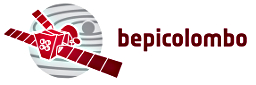

- Jupyter For BepiColombo
  - currently several users are developing Notebooks internally
    - often would like to share with users
    - rendering of ipynb would be great!
    - can be done with BitBucket with appropriate plugins
  - we are developing a Quick-Look Analysis (QLA) sytem
    - this works with PDS-formatted products, generated automatically every pass
    - provides visualisation of science data and housekeeping
  - eventually being able to analyse data in Jupyter would be great
    - for SGS users, but also for external users
      - with appropriate access control
      
      
      
